# Topographic Controls on Supraglacial Meltwater Drainage Systems on Antarctic Ice Shelves.

## Julian Spergel, Jonathan Kingslake
### Topographic Controls on Supraglacial Meltwater Drainage Systems on Antarctic Ice Shelves.

In [1]:
conda install -c conda-forge ipywidgets

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.

ResolvePackageNotFound: 
  - python==3.7


Note: you may need to restart the kernel to use updated packages.


In [87]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import dask
import dask.delayed
import numpy as np
import xarray as xr
import geopandas as gpd
import hvplot.xarray
from matplotlib import pyplot as plt
import matplotlib.image as mplimage
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import shapefile
import shapely
import os
import dask
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da
import pandas as pd

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

In [3]:
#We have translated a number of functions to calculate hydrology catchment divides from Matlab's TopoToolbox (2014) 
import HydrologyFunctions as hy

Text(0.5, 1.0, 'https://nsidc.org/sites/nsidc.org/files/images/iceshelf_locations.png')

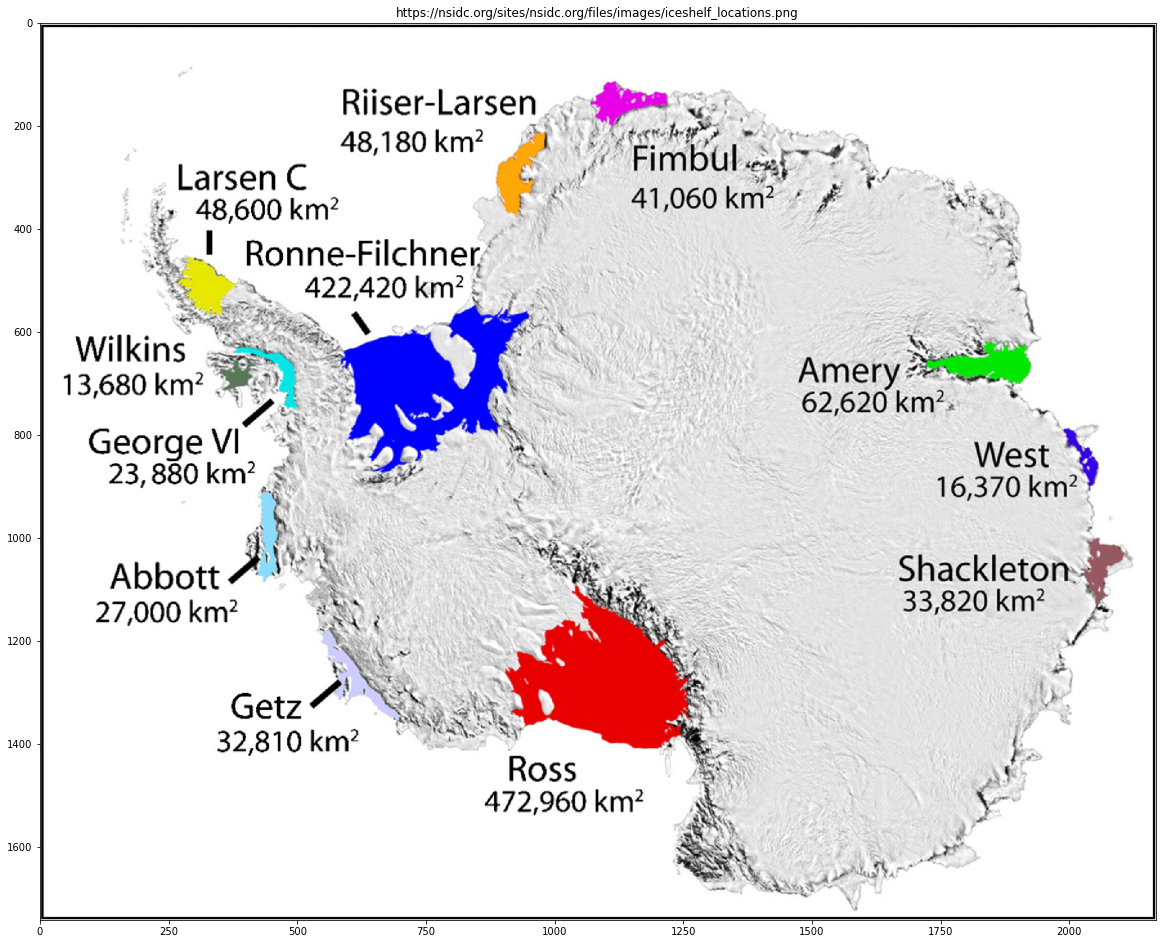

In [4]:
image = mplimage.imread('https://nsidc.org/sites/nsidc.org/files/images//iceshelf_locations.png')
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.title('https://nsidc.org/sites/nsidc.org/files/images/iceshelf_locations.png')

In [5]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 
#read in the REMA tile index
REMA_index = gpd.read_file('REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')

In [6]:
def f(shelf):#select an ice shelf, the Amery Ice Shelf in east Antarctica
    SelectedIceShelf = IS[IS.NAME==shelf]
    fig,axis = plt.subplots()
    REMA_index.plot(ax=axis)
    SelectedIceShelf.geometry.plot(ax=axis,color='r')

In [7]:
w = interactive(f,shelf = list(IS.NAME))

In [8]:
display(w)

interactive(children=(Dropdown(description='shelf', options=('Dawson_Lambton', 'Philbin_Inlet', 'Walgreen_Coas…

In [196]:
sample = hy.download_REMA(w.kwargs['shelf'])

[############                            ] | 30% Completed | 29.0s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 15.3s


<AxesSubplot:title={'center':'band = 1'}, xlabel='x', ylabel='y'>

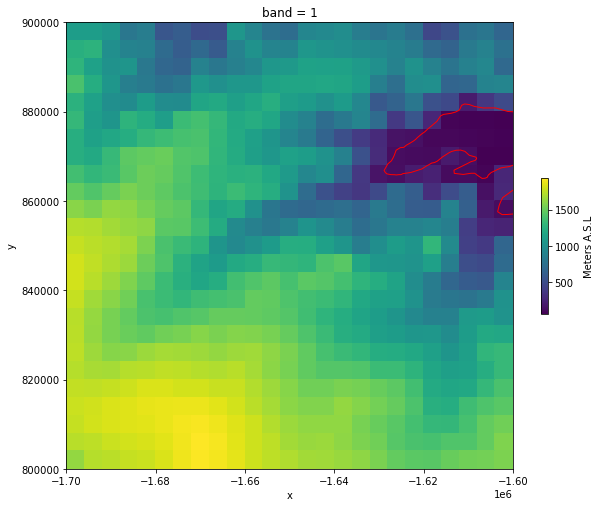

In [197]:
fig, ax = plt.subplots(figsize=(10,10))
with ProgressBar():
    dem_plot = sample.coarsen(x=5,y=5).mean().plot(ax=ax,add_colorbar=False)
plt.colorbar(dem_plot, shrink=0.25, label='Meters A.S.L')
SelectedIceShelf = IS[IS.NAME==w.kwargs['shelf']]
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='r')

In [198]:
#Normally we'd test to see if there is missing data, but for this sample notebook, we'll assume that yes, there is missing data. 
flag_nans = True 

In [199]:

identified_flats = sample.data.map_blocks(hy.identifyflats, dtype=float)
identified_sills = dask.array.map_blocks(lambda dem,flats: hy.identifysills(dem,flats), sample.data, identified_flats, dtype=float)
identified_interbasins = sample.data.map_overlap(lambda dem: hy.identifyinteriorbasins(dem), depth=1, dtype=float)
cellsize = 8*100*8*100
FlowObj_dask = lambda dem,flats,sills,interiorbasins: hy.drainagebasins(dem,flats,sills,interiorbasins,cellsize)

[##                                      ] | 6% Completed | 10.0s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[####################################### ] | 99% Completed | 44.1s

/home/jovyan/REMAWaterRouting/HydrologyFunctions.py:396: RuntimeWarning: invalid value encountered in subtract
  D = ((skimage.morphology.reconstruction(seed = D+1,mask=masked,method='erosion'))- D) *cellsize
/home/jovyan/REMAWaterRouting/HydrologyFunctions.py:401: RuntimeWarning: divide by zero encountered in reciprocal
  cost_field  = map_image_to_costs(D**-1,PreSillPixel)
/home/jovyan/REMAWaterRouting/HydrologyFunctions.py:163: RuntimeWarning: invalid value encountered in subtract
  G = (D-np.min(D))/(np.max(D)-np.min(D))**-1
/home/jovyan/REMAWaterRouting/HydrologyFunctions.py:163: RuntimeWarning: invalid value encountered in double_scalars
  G = (D-np.min(D))/(np.max(D)-np.min(D))**-1


[########################################] | 100% Completed | 44.5s


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


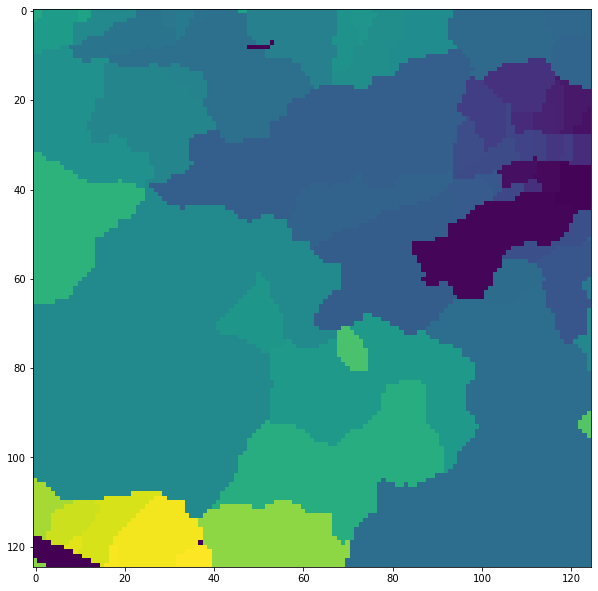

In [200]:
FlowObj_values = dask.array.map_overlap(FlowObj_dask,sample.data,identified_flats,identified_sills,identified_interbasins,dtype=float, depth=10, align_arrays=True)
with ProgressBar():
    DB = FlowObj_values.compute()
plt.figure(figsize=(10,20))
plt.imshow(DB)

In [201]:
def cleandrainagebasins(D):
    D_labelled = skimage.morphology.label(D)

    D_labelled_new = D

    #merge down
    for i in np.arange(250,D.shape[0]-1,250):
        topside = D[i-1,:]
        topside_values = np.argwhere(np.diff(topside)!=0)
        for ii in np.arange(0,len(topside_values)):
            col_to_merge = topside_values[ii]
            basin_to_merge = D_labelled[i,col_to_merge]
            mask_right = np.argwhere(D_labelled == basin_to_merge)
            [mask_x,mask_y] = np.array(mask_right).T
            D_labelled_new[mask_x,mask_y] = D[i-1,topside_values[ii]]

    #Merge left
    for i in np.arange(250,D.shape[1],250):
        leftside = D_labelled[:,i-1]
        leftside_values = np.argwhere(np.diff(leftside)!=0)
        for ii in np.arange(0,len(leftside_values)):
            row_to_merge = leftside_values[ii]
            basin_to_merge = D_labelled[row_to_merge,i]
            D_labelled_new[D_labelled == basin_to_merge] = D[leftside_values[ii],i-1]

    xarray_D = xr.DataArray(data = D_labelled_new, coords = sample.coords,dims = sample.dims, attrs = sample.attrs)
    return xarray_D

<AxesSubplot:title={'center':'band = 1'}, xlabel='x', ylabel='y'>

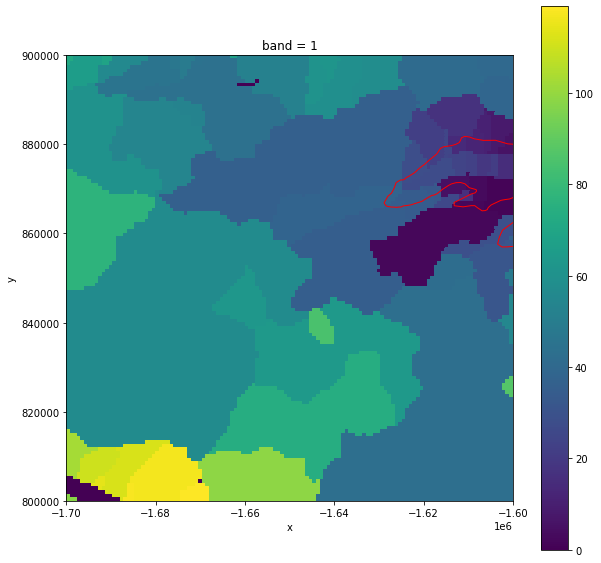

In [202]:
with ProgressBar():
    D_new = cleandrainagebasins(DB)
fig, ax = plt.subplots(figsize=(10,10))
D_new.plot(ax=ax)
SelectedIceShelf = IS[IS.NAME==w.kwargs['shelf']]
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='r')

In [203]:
def filledbasins(dem):
    Inans = dask.array.isnan(dem)
    dem_nonans =  dem.fillna(-np.inf)
    marker = np.negative(dem_nonans);
    #dem = dem + np.multiply(Inans,-np.inf)
    II = np.zeros(dem.shape);
    II[1:-1,1:-1] = 1;
    mask = np.bitwise_and(np.bool_(II),~Inans)*-np.inf
    marker = marker+mask;
    demfs = -skimage.morphology.reconstruction(marker,-dem_nonans, method='dilation')
    return demfs

demfs_task = lambda dem: filledbasins(dem)
with ProgressBar():
    demfs = dask.array.map_blocks(demfs_task, dem=sample, dtype=float)

[########################################] | 100% Completed | 50.4s
[####################################### ] | 98% Completed | 37.2s


In [204]:
with ProgressBar():
    demfs = demfs.persist()

[############                            ] | 30% Completed |  7.0s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 28.3s


In [205]:
with ProgressBar():
    demfs = demfs.compute()

[########################################] | 100% Completed |  0.1s


In [206]:
depths = dask.array.subtract(demfs,sample.data)

In [207]:
depths

dask.array<subtract, shape=(125, 125), dtype=float64, chunksize=(125, 125), chunktype=numpy.ndarray>

In [208]:
with ProgressBar():
    Depths = depths.compute()

[#####                                   ] | 13% Completed |  7.9s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 35.9s


In [209]:
Depths_Array = sample
Depths_Array.data = Depths

<AxesSubplot:title={'center':'band = 1'}, xlabel='x', ylabel='y'>

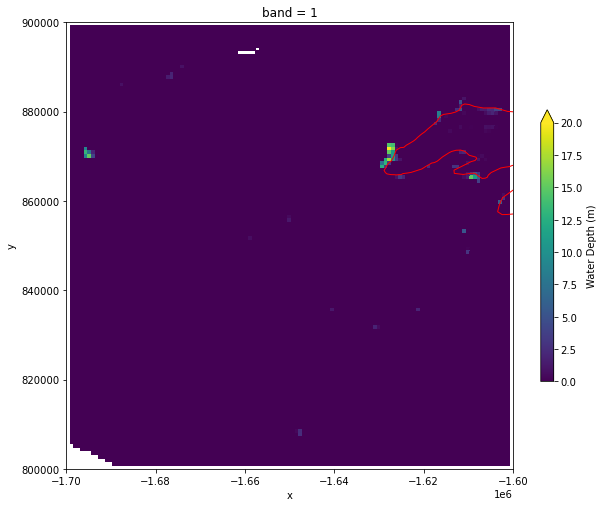

In [210]:
fig, ax = plt.subplots(figsize=(10,10))
depthplot = Depths_Array.plot(ax=ax,vmax=20,add_colorbar=False)
plt.colorbar(depthplot,label='Water Depth (m)', shrink=0.5, extend='max')
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='r')

In [211]:
with ProgressBar():
    #Build  data structure  on each drainage Catchments

    b_dict = {'CatchmentNumber','CatchmentArea','MaskLogical','MaskI','MaskXY','skip','Volume','maxdepth','hw','h','p'}
    b = pd.DataFrame(data={},columns=b_dict)

    histcount = np.bincount(D_new.data.ravel())
    catchment_num = np.max(D_new.data.ravel())
    valid_catchment= []
    for kk in np.arange(0,catchment_num):
        CatchmentNumber = kk;
        Mask = D_new.data == kk; 
        CatchmentArea = (np.sum(np.int_(Mask.ravel()))*cellsize); # basin area in m^2
        if CatchmentArea>0:
            valid_catchment = np.append(valid_catchment,kk)


    for catchment in valid_catchment:
        CatchmentNumber = catchment;
        Mask = D_new.data == catchment; 
        CatchmentArea = (np.sum(np.int_(Mask.ravel()))*cellsize); # basin area in m^2
        MaskLogical = Mask;
        MaskXY = np.where(Mask);  # mask for the basin
        MaskI= np.ravel_multi_index(MaskXY,sample.shape)
        depths = Depths_Array.data[MaskXY] #Water accomodation space in drainage basin
        if np.count_nonzero(depths>0)<4: #If accomodation space is zero, i.e, no nonzero depths
            skip = 1;
            h = 0;
            maxdepth = 0;
            Volume = 0;
            hw = np.zeros(depths.size)
            continue
        else:
            valid = np.argwhere(depths>=0)
            depths = depths[valid];
            heights = np.max(depths) - depths; #potential water height from bottom
            skip = 0;        
            Volume = (np.sum(depths.ravel())*cellsize);
            heights_sorted = np.sort(list(heights.flatten()));
            while len(np.argwhere(np.diff(heights_sorted)==0))>0: #remove all identical pixels
                I = np.argwhere(np.diff(heights_sorted)==0);
                heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
            hw = heights_sorted;   # heights for hypsometry
            maxdepth = np.max(depths); # not actually the same as max(Heights) the smallest value of depths is not equal to demero
            h = 0;   # initial water depth is demero
            volume = np.zeros((len(heights)-1,1));
            if np.count_nonzero(depths)>5:
                totalVolume = Volume;
                for i in np.arange(0,len(heights)-1):
                    volume[i] = (volume[i-1]+ (hw[i+1]-hw[i])*(i*cellsize));

                Y = (np.log(volume/totalVolume));
                X  = list(np.log(hw[0:-1]/maxdepth)),
                X = X[0]
                X.pop(0)
                Y = list(Y.flatten())
                Y.pop(0)
                reg = np.polyfit(list(X),list(Y),1)

                p = reg[0];
            else:
                p = 1;
        data={'CatchmentNumber':CatchmentNumber,
               'CatchmentArea':CatchmentArea,
               'MaskLogical':MaskLogical.ravel(),
               'MaskI':MaskI,
                'MaskXY': MaskXY,
               'skip':skip,
               'Volume':Volume,
               'maxdepth':maxdepth,
               'hw':hw,
               'h':h,
               'p':p
                }
        DrainageBasin = pd.Series(data)
    #else:
        #continue
        b = b.append(DrainageBasin, ignore_index=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


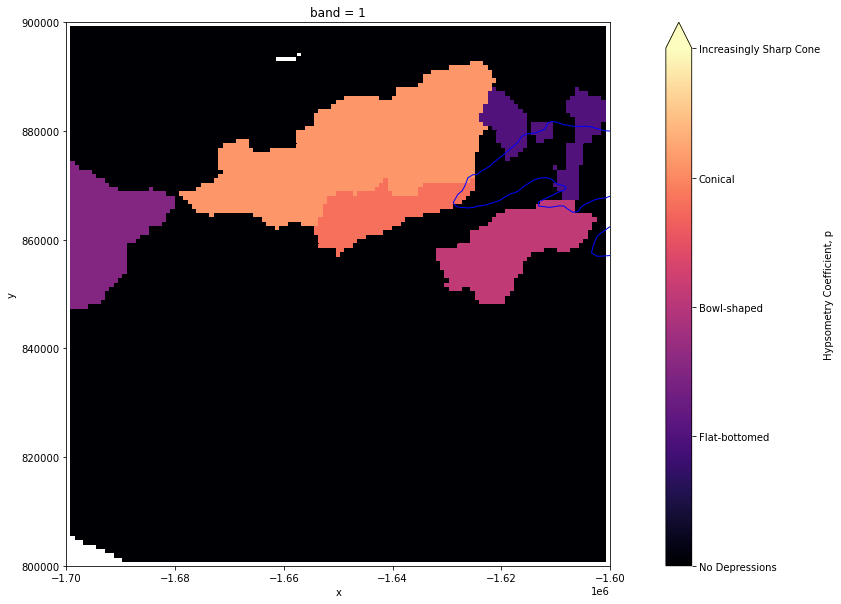

In [212]:
p_map = np.zeros(Depths_Array.shape)

for c in np.arange(0,len(b)):
    p_map[b['MaskXY'][c]] = b['p'][c]*np.ones((1,len(b['MaskI'][c])))

Pmap = D_new
nan_mask = np.ones(D_new.shape)
nan_mask[np.isnan(sample)] = np.nan
Pmap.data = p_map*nan_mask


fig, ax = plt.subplots(figsize=(20,10))
pplot = Pmap.plot(ax=ax,vmax=4,cmap='magma',add_colorbar=False)
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='b')
cbar = plt.colorbar(pplot,label='Hypsometry Coefficient, p',ticks=[0,1,2,3,4],extend='max')
cbar.ax.set_yticklabels(['No Depressions','Flat-bottomed','Bowl-shaped','Conical','Increasingly Sharp Cone']);


<AxesSubplot:title={'center':'band = 1'}, xlabel='x', ylabel='y'>

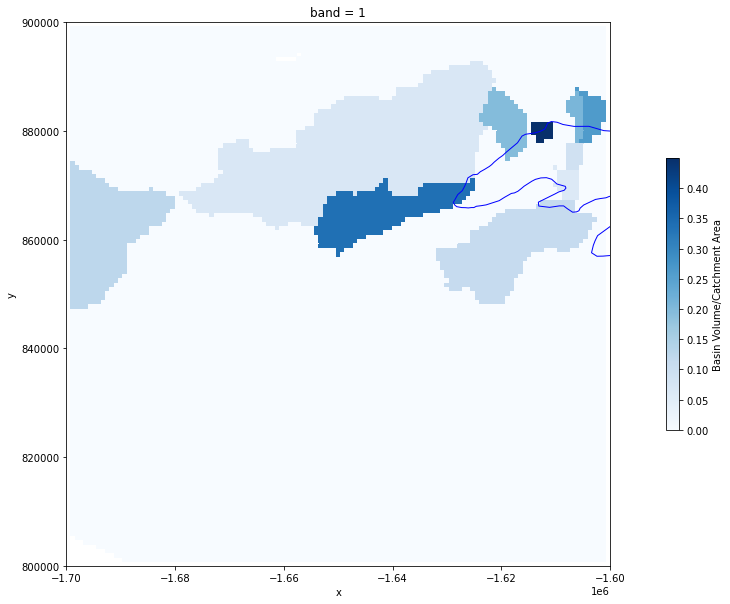

In [213]:
ratio_map = np.zeros(Depths_Array.shape)

for c in np.arange(0,len(b)):
    ratio_map[b['MaskXY'][c]] = (b['Volume'][c]/b['CatchmentArea'][c])*np.ones((1,len(b['MaskI'][c])))

ratiomap = D_new
ratiomap.data = ratio_map*nan_mask

fig, ax = plt.subplots(figsize=(20,10))

ratioplot = ratiomap.plot(ax=ax,cmap='Blues', cbar_kwargs={'shrink':0.5,'label':'Basin Volume/Catchment Area'})
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='b')
#plt.title('Basin Volume/Catchment Area')